# How do empty stadiums affect home field advantage in baseball?

Every since I was a kid 'home field advantage' has interested me. Why do these players do better at home? They're professional athletes surely they play hard all the time and not just when they have people cheering for them. I remember playing sports in middle school and when we had a home game thinking "We're the home team today, I'm going to play better!". 

The items most prominently referenced as the drivers are 1) Fans/Noise 2) Comfort of home and routine. While watching Brady Singer's debut for the Royals, I realized the 2020 season is a golden opportunity to isolate those two variables for each other and see what the effect is. Without fans in the stadium, does home field advantage still exist?

This analysis isn't intended to prove home field advantage exists. A quick google search will yield [mounds of evidence](https://www.sbnation.com/2011/1/19/1940438/home-field-advantage-sports-stats-data) for that. But I will measure how 2020 win rates at home compare to historic years.

For those who want a quick answer, I'll lead with a pretty chart that has your answer.

Given the internet is light on great examples of the sportsreference API, I've included full code with some light commentary in case it may be of use.

You can also find the full code at https://github.com/jvonfeldt/CovidBaseball.

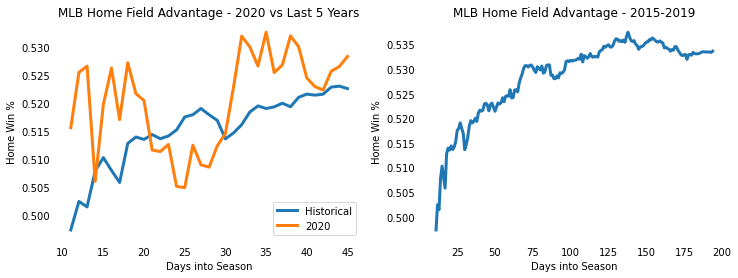

In [51]:
#Plot figures
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

dfh_n.plot(title = 'MLB Home Field Advantage - 2015-2019', xlabel = 'Days into Season', ylabel = 'Home Win %',
           ax=ax2,linewidth=3)
dfva.plot(title = 'MLB Home Field Advantage - 2020 vs Last 5 Years', xlabel = 'Days into Season', ylabel = 'Home Win %',
          ax=ax1,linewidth=3)

ax1.legend(['Historical','2020'],loc='lower right')

for ax in [ax1,ax2]:
    for s in ax.spines:
        ax.spines[s].set_visible(False)
    ax.tick_params(left=False,bottom=False)

# Commentary

33 days into the season and it doesn't look like we have a definitive answer. Baseball is a game of sample size and (hopefully) we'll never achieve that. You can see that over the last 5 years it takes a few months into the seasons for the effects of home field advantage to be seen. You'll also note that overall the homefield time only wins 3% above a 50/50 split, the lowest in all major sports. 

I'll update this througout the season.

In [50]:
#This project is all derived from the sportsreference API. Shout out to them. You can find documentation here:
# https://sportsreference.readthedocs.io/en/stable/index.html

from sportsreference.mlb.teams import Teams
from sportsreference.mlb.boxscore import Boxscores


#Basic imports - I dont' have any additional color
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pickle
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cm'

In [6]:
#Function to pull win data for a whole season. Input is two datetime objects specficying date range you want to pull games for
#Use season_length function to find opening day and last regular season game for a year
  
    
def season(mydates):
    #Pull boxscores for every day in the specified range
    for c, day in enumerate(mydates):
        scores = Boxscores(day)

        # Date formatting - Replace removes 0's from day -- L strip removes 0's from month
        day = day.strftime('%m-%d-%Y').lstrip("0").replace("-0", "-")
        allscores = scores.games[day]
        daytallyh = []
        daytallya = []

        #Pull boxscores for every game in a day
        for counter, game in enumerate(allscores):


            #For each game, determine who the winner is
            boxscore = allscores[counter]
            ar = boxscore['away_score']
            hr = boxscore['home_score']
            winner = hr > ar
            if winner is True:
                hw = 1
                aw = 0
                daytallyh.append(hw)
            else:
                hw = 0
                aw = 1
                daytallya.append(aw)

        #Organize daily data
        hwc = np.sum(daytallyh)
        awc = np.sum(daytallya)
        totalgames = hwc + awc
        sch_len = c + 1
        daydata = pd.DataFrame({'Date':[day],'HW':[hwc],'AW':[awc],'Games':[totalgames],'Sch_len':[sch_len]})
        try:
            wintable = wintable.append(daydata)
        except:
            wintable = pd.DataFrame({'Date':[day],'HW':[hwc],'AW':[awc],'Games':[totalgames],'Sch_len':[sch_len]})
    return wintable


In [7]:
#Returns opening day and closing day for that years regular season
#Takes a year as input


#Do this for each team because we don't know who played on opening day here
def season_length(year):
    all_dates = []
    for team in Teams(year):

        schedule = team.schedule

        #Find the dates of games for each team
        for game in schedule:

            date = game.date
            try:
                date = datetime.strptime(date,'%A, %b %d')

            except:
                a = len(date)
                b = date[0:-4]
                date = datetime.strptime(b,'%A, %b %d')
                all_dates.append(date)

            all_dates.append(date)

    #Min and mix dates for all teams are opening and closing day for a season
    opening_day = min(all_dates)
    closing_day = max(all_dates)
    i = int(year)
    opening_day = opening_day.replace(year=i)
    closing_day = closing_day.replace(year=i)
    return opening_day, closing_day


In [ ]:
# Beginning of analysis
# Let's compare 2020 to last 5 years of data

# Note: This will take a while to run

years = ['2019','2018','2017','2016','2015']

alltables = {}

# Run previously defined functions for each of the last 5 complete seasons
for i in years:
    o, c = season_length(i)
    mydates = pd.date_range(o, c)
    alltables[i] =  season(mydates)
    

In [9]:
## Pull data for the 2020 season

thisyear = {}

o = datetime(2020,7,23)
c = datetime.today() - timedelta(days=1)

mydates = pd.date_range(o, c)
thisyear =  season(mydates)

In [ ]:
#Save historic data to pkl so I don't have wait for function to pull data when everytime I want to analysis it

# pickle.dump(alltables, open('last5.p','wb')) - commented out since I pull from pickle now

In [10]:
# Read historic data

last5 = pickle.load(open('last5.p','rb'))

# Read this year data

# thisyear = pickle.load(open('last5.p','rb')) - commented out for now 

In [11]:
# Combine last 5 years of wins by day in season
# Doesn't reset variable, so if you run multiple times it will compound

for i in last5: 
    df = pd.DataFrame(last5[i])
    df = df.set_index('Sch_len')
    df['total_HW'] = df['HW'].cumsum()
    df['total_G'] = df['Games'].cumsum()
    df = df.loc[:,['HW','Games']]
    try:
        df1 = df1.add(df,fill_value = 0)
    except:
        df1 = df

In [12]:
## Sort/Apply data and plot

df = df1

#Converting into win %
df['total_HW'] = df['HW'].cumsum()
df['total_G'] = df['Games'].cumsum()
df['hwp'] = df['total_HW']/df['total_G']

dfh_full = df.loc[:,'hwp']

#There's a lot of vol early in the year, skipping first 10 days of season to normalize
dfh_n = dfh_full.iloc[10:]

In [13]:
#Format 2020 table for plotting

df = pd.DataFrame(thisyear)

df = df.set_index('Sch_len')
df['total_HW'] = df['HW'].cumsum()
df['total_G'] = df['Games'].cumsum()
df['2020hwp'] = df['total_HW']/df['total_G']
df2020 = df.loc[:,['2020hwp']]
df2020_n = df2020.iloc[10:]

In [14]:
#Combine 2020 and historic data
a = dfh_full.reset_index()
b = df2020.reset_index()
dfv = pd.merge(a, b, on = 'Sch_len', how = 'inner')
dfv = dfv.set_index('Sch_len')
dfva = dfv.iloc[10:]